In [54]:
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import logging as log
from stompy.grid import unstructured_grid
import glob
from stompy.plot import plot_wkb
import six
import stompy.plot.cmap as scmap

import os
from stompy import utils
import xarray as xr
%matplotlib notebook


In [55]:
import postprocess_v00 as post
six.moves.reload_module(post)

<module 'postprocess_v00' from '/home/rusty/src/microplastic_sfbay/postprocess/postprocess_v00.py'>

In [56]:
grid_fn="/opt2/sfb_ocean/suntans/runs/merged_018_20171227/ptm_average.nc_0000.nc"  
grid=post.grid_from_ptm_hydro(grid_fn)
M=grid.smooth_matrix(f=0.5,dx='grid',A='grid',V='grid',K='scaled')

INFO:utils:58820/99089


In [57]:
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


In [58]:
def smooth(c): 
    for _ in range(20):
        c=M.dot(c)
    return c

In [59]:
#cmap=scmap.load_gradient('001-fire.cpt',reverse=True)
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

In [81]:
class BayConcFigure(object):
    figsize=(8.4,8)
    ax=None
    fig=None
    vmin=1e-5
    vmax=10.0
    zoom=(517521., 609000., 4139744., 4230000.)
    cmap=cmap
    cax_loc=[0.7,0.25,0.03,0.35]
    txt_loc=[0.65,0.7] # in ax coords
    cbar_label="Particles/m$^2$"
    draw_boundary=True
    extra_text=[]
    num=None
    def __init__(self,ds,conc=None,**kw):
        utils.set_keywords(self,kw)
        self.ds=ds
        if conc is None:
            conc=self.ds['conc'].values

        if self.fig is None:
            self.fig=plt.figure(figsize=self.figsize,num=self.num)
        if self.ax is None:
            self.ax=self.fig.add_subplot(1,1,1)
        
        self.ccoll=grid.plot_cells(values=conc.clip(self.vmin,self.vmax),
                                   cmap=self.cmap,norm=colors.LogNorm(vmin=self.vmin,vmax=self.vmax),
                                   edgecolor='face',lw=0.4,ax=self.ax)
        if self.draw_boundary:
            self.boundary=plot_wkb.plot_wkb(grid_poly,ax=self.ax,ec='k',lw=0.5,fc='none')
        if self.cax_loc is not None:
            self.cax=self.fig.add_axes(self.cax_loc) # Need refactor
            plt.colorbar(self.ccoll,cax=self.cax,label=self.cbar_label,extend='both')
        self.ax.axis('equal')
        self.ax.axis(self.zoom)
        self.ax.xaxis.set_visible(0)
        self.ax.yaxis.set_visible(0)
        self.fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01)
        
        self.add_labels()
    def __del__(self):
        self.ds.close()
    def add_labels(self):
        texts=[self.behavior_label()]
        texts.append(self.average_label())
        texts.append(self.date_label())
        texts+=self.extra_text
        self.ax.text(self.txt_loc[0],self.txt_loc[1],"\n".join(texts),
                     fontsize=14,va='top',ha='left',transform=self.ax.transAxes)
    def behavior_label(self):
        # go from a list of groups to a label
        behaviors=[ post.PtmRun.group_to_src_behavior(group)[1]
                    for group in self.ds.ptm_groups.values ]
        behaviors.sort()
        assert behaviors[0]==behaviors[-1]
        behavior=behaviors[0]
        if behavior=='none':
            label='Passive'
        elif behavior.startswith('up'):
            w_mmps=float(behavior.replace('up',''))/1000.0
            label=f'Rise {w_mmps:.1f} mm/s'
        elif behavior.startswith('down'):
            w_mmps=float(behavior.replace('down',''))/1000.0
            label=f'Sink {w_mmps:.1f} mm/s'
        return label
    
    def date_label(self):
        def fmt_t(t): return utils.to_datetime(t).strftime('%Y-%m-%d')
        return f"{fmt_t(self.ds.time_start)} – {fmt_t(self.ds.time_end)}"
    
    def average_label(self):
        if np.all(self.ds.z_range.values==[0,0.5]):
            return "Near bed"
        elif np.all(self.ds.z_range.values==[-0.5,0.0]):
            return "Near surface"
        elif np.all(self.ds.z_range.values==[0,0]):
            return "Full depth"
        else:
            return "Vertical range: %.2f – %.2f"%(self.ds.z_range.values[0],
                                                  self.ds.z_range.values[1])

# Same idea but settings for coastal region.
# note that with the 15 day output, these get truncated
# and show little action in the ocean.
class CoastalConcFigure(BayConcFigure):
    figsize=(7,8.1)
    zoom=(345000., 613202., 4050000., 4230105.)
    cax_loc=[0.05,0.20,0.03,0.35]
    txt_loc=[0.05,0.13] # in ax coords
    

In [65]:
display=False
force=False

if not display: plt.ioff()

fns=glob.glob('processed/201*_201*/[-0-9]*/particles*-v05.nc')
fns.sort()
for ptm_conc in fns:
    ds=None
    conc=None
    for config in ['bay','coast']:
        img_fn=ptm_conc.replace('.nc',f'-{config}.png')
        
        if (not display) and os.path.exists(img_fn) and not force: 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        if ds is None:
            ds=xr.open_dataset(ptm_conc)
        if conc is None:
            conc=smooth(ds.conc.values)
        if config=='bay':
            bf=BayConcFigure(ds,conc=conc)
        elif config=='coast':
            bf=CoastalConcFigure(ds,conc=conc)
        else:
            raise Exception(f"Bad config {config}")
        if display:
            break
        bf.fig.savefig(img_fn,dpi=150)
        plt.close(bf.fig)
    
if not display: plt.ion()

INFO:root:processed/20170630_20170715/-0.0005/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20170630_20170715/-0.005/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20170630_20170715/-0.005/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20170630_20170715/-0.005/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20170630_20170715/-0.005/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20170630_20170715/-0.005/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20170630_201707

INFO:root:processed/20170830_20170914/-0.005/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20170830_20170914/-0.05/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20170830_20170914/-0.05/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20170830_20170914/-0.05/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20170830_20170914/-0.05/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20170830_20170914/-0.05/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20170830_20170914/-0.05/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20170830_20170914/0.0/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20170830_20170914/0.0/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20170830_20170914/0.0/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20170830_20170914/0.0/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20170830_20170914/0.0/particles-surf-

INFO:root:processed/20171030_20171114/0.0/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20171030_20171114/0.0/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20171030_20171114/0.0005/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20171030_20171114/0.0005/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20171030_20171114/0.0005/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20171030_20171114/0.0005/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20171030_20171114/0.0005/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20171030_20171114/0.0005/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20171030_20171114/0.005/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20171030_20171114/0.005/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20171030_20171114/0.005/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20171030_20171114/0.005/parti

INFO:root:processed/20171230_20180114/0.005/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20171230_20180114/0.005/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20171230_20180114/0.005/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20171230_20180114/0.05/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20171230_20180114/0.05/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20171230_20180114/0.05/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20171230_20180114/0.05/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20171230_20180114/0.05/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20171230_20180114/0.05/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20180130_20180214/-0.0005/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20180130_20180214/-0.0005/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20180130_20180214/-0.0005/parti

INFO:root:processed/20180330_20180414/-0.0005/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20180330_20180414/-0.0005/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20180330_20180414/-0.0005/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20180330_20180414/-0.0005/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20180330_20180414/-0.005/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20180330_20180414/-0.005/particles-avg-15days-v05-coast.png: exists
INFO:root:processed/20180330_20180414/-0.005/particles-bed-15days-v05-bay.png: exists
INFO:root:processed/20180330_20180414/-0.005/particles-bed-15days-v05-coast.png: exists
INFO:root:processed/20180330_20180414/-0.005/particles-surf-15days-v05-bay.png: exists
INFO:root:processed/20180330_20180414/-0.005/particles-surf-15days-v05-coast.png: exists
INFO:root:processed/20180330_20180414/-0.05/particles-avg-15days-v05-bay.png: exists
INFO:root:processed/20180330_20180414

In [66]:
# The combined figures
display=False

if not display: plt.ioff()

fns=glob.glob('processed/201*_201*/[-0-9]*/particles*-v05A.nc')
fns.sort()
for ptm_concA in fns:
    ptm_concB=ptm_concA.replace('v05A','v05B')
    assert ptm_concB!=ptm_concA
    
    dsA=None
    dsB=None
    conc=None
    for config in ['bay','coast']:
        img_fn=ptm_concA.replace('v05A','v05AB45').replace('.nc',f'-{config}.png')
    
        if (not display) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        if dsA is None:
            dsA=xr.open_dataset(ptm_concA)
        if dsB is None:
            dsB=xr.open_dataset(ptm_concB)
        if conc is None:
            conc=smooth(dsA.conc.values+dsB.conc.values)
        kw=dict(extra_text=['45 day cutoff'])
        if config=='bay':
            bf=BayConcFigure(dsA,conc=conc,txt_loc=[0.65,0.75],**kw)
        elif config=='coast':
            bf=CoastalConcFigure(dsB,conc=conc,**kw)
        else:
            raise Exception(f"Bad config {config}")
        if not display:
            bf.fig.savefig(img_fn,dpi=150)
            plt.close(bf.fig)
    if display:
        break
    
    if not display: plt.ion()

INFO:root:processed/20170729_20170812/-0.0005/particles-avg-44days-v05AB45-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-avg-44days-v05AB45-coast.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-surf-44days-v05AB45-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-surf-44days-v05AB45-coast.png: exists
INFO:root:processed/20170729_20170812/-0.005/particles-avg-44days-v05AB45-bay.png: exists
INFO:root:processed/20170729_20170812/-0.005/particles-avg-44days-v05AB45-coast.png: exists
INFO:root:processed/20170729_20170812/-0.005/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20170729_20170812/-0.005/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20170729_20170812/-0.005/particles-surf-44days-v05AB45-bay.png

INFO:root:processed/20170928_20171012/-0.005/particles-avg-44days-v05AB45-coast.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-surf-44days-v05AB45-bay.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-surf-44days-v05AB45-coast.png: exists
INFO:root:processed/20170928_20171012/-0.05/particles-avg-44days-v05AB45-bay.png: exists
INFO:root:processed/20170928_20171012/-0.05/particles-avg-44days-v05AB45-coast.png: exists
INFO:root:processed/20170928_20171012/-0.05/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20170928_20171012/-0.05/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20170928_20171012/-0.05/particles-surf-44days-v05AB45-bay.png: exists
INFO:root:processed/20170928_20171012/-0.05/particles-surf-44days-v05AB45-coast.png: exists


INFO:root:processed/20171128_20171212/-0.05/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20171128_20171212/-0.05/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20171128_20171212/-0.05/particles-surf-44days-v05AB45-bay.png: exists
INFO:root:processed/20171128_20171212/-0.05/particles-surf-44days-v05AB45-coast.png: exists
INFO:root:processed/20171128_20171212/0.0/particles-avg-44days-v05AB45-bay.png: exists
INFO:root:processed/20171128_20171212/0.0/particles-avg-44days-v05AB45-coast.png: exists
INFO:root:processed/20171128_20171212/0.0/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20171128_20171212/0.0/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20171128_20171212/0.0/particles-surf-44days-v05AB45-bay.png: exists
INFO:root:processed/20171128_20171212/0.0/particles-surf-44days-v05AB45-coast.png: exists
INFO:root:processed/20171128_20171212/0.0005/particles-avg-44days-v05AB45-bay.png: exists
INFO:root:processe

INFO:root:processed/20180128_20180211/0.0/particles-bed-44days-v05AB45-bay.png: processing
INFO:root:processed/20180128_20180211/0.0/particles-bed-44days-v05AB45-coast.png: processing
INFO:root:processed/20180128_20180211/0.0/particles-surf-44days-v05AB45-bay.png: processing
INFO:root:processed/20180128_20180211/0.0/particles-surf-44days-v05AB45-coast.png: processing
INFO:root:processed/20180128_20180211/0.0005/particles-avg-44days-v05AB45-bay.png: processing
INFO:root:processed/20180128_20180211/0.0005/particles-avg-44days-v05AB45-coast.png: processing
INFO:root:processed/20180128_20180211/0.0005/particles-bed-44days-v05AB45-bay.png: processing
INFO:root:processed/20180128_20180211/0.0005/particles-bed-44days-v05AB45-coast.png: processing
INFO:root:processed/20180128_20180211/0.0005/particles-surf-44days-v05AB45-bay.png: processing
INFO:root:processed/20180128_20180211/0.0005/particles-surf-44days-v05AB45-coast.png: processing
INFO:root:processed/20180128_20180211/0.005/particles-avg-

INFO:root:processed/20180331_20180414/0.0005/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20180331_20180414/0.0005/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20180331_20180414/0.0005/particles-surf-44days-v05AB45-bay.png: exists
INFO:root:processed/20180331_20180414/0.0005/particles-surf-44days-v05AB45-coast.png: exists
INFO:root:processed/20180331_20180414/0.005/particles-avg-44days-v05AB45-bay.png: exists
INFO:root:processed/20180331_20180414/0.005/particles-avg-44days-v05AB45-coast.png: exists
INFO:root:processed/20180331_20180414/0.005/particles-bed-44days-v05AB45-bay.png: exists
INFO:root:processed/20180331_20180414/0.005/particles-bed-44days-v05AB45-coast.png: exists
INFO:root:processed/20180331_20180414/0.005/particles-surf-44days-v05AB45-bay.png: exists
INFO:root:processed/20180331_20180414/0.005/particles-surf-44days-v05AB45-coast.png: exists
INFO:root:processed/20180331_20180414/0.05/particles-avg-44days-v05AB45-bay.png: exists
INFO

INFO:root:processed/20170630_20170715/particles-avg-15days-v05-bay-8panel.png: processing


<IPython.core.display.Javascript object>


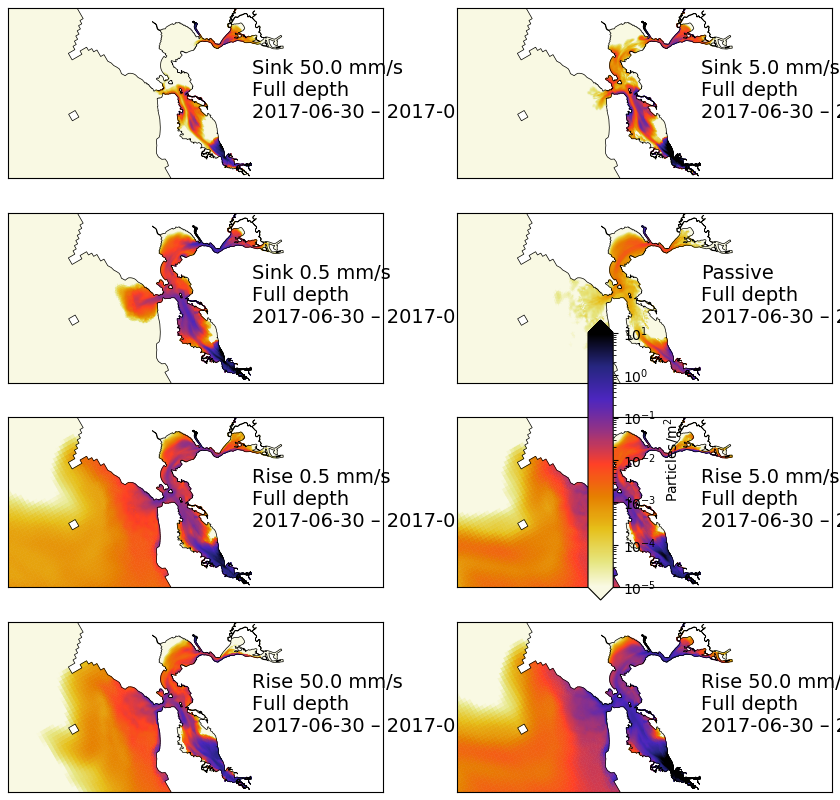

In [84]:
class MissingFiles(Exception): pass

class WsPanels(object):
    all_w_s=["-0.05","-0.005","-0.0005",
             "0.0",
             "0.0005","0.005","0.05"]
    figsize=(8.4,8)
    num=None
    PlotClass=BayConcFigure
    
    def __init__(self,ptm0_conc,**kw):
        """
        ptm0_conc: path to the w_s=0.0 netcdf file.
        assumes that /0.0/ appears in the path, and
        can be replaced by the other settling velocities
        """
        utils.set_keywords(self,kw)
        
        ptm_concs=[ptm0_conc.replace("/0.0/","/"+w_s+"/")
                   for w_s in self.all_w_s]
        if not all([os.path.exists(fn) for fn in ptm_concs]):
            log.warning("{ptm_conc} did not have all w_s - skip")
            raise MissingFiles()
        
        if self.num is not None:
            fig=plt.figure(figsize=self.figsize,num=self.num)
            fig.clf()
            fig.set_size_inches(self.figsize,forward=True)            
        self.fig,self.axs=plt.subplots(4,2,num=self.num,figsize=self.figsize)
        
        self.bfs=[]
        sum_conc=0.0
        for w_s,ptm_conc,ax in zip(self.all_w_s+['sum'],
                                   ptm_concs+['sum'],
                                   self.axs.ravel()):
            if ptm_conc=='sum':
                conc=sum_conc
            else:
                ds=xr.open_dataset(ptm_conc)
                conc=smooth(ds.conc.values)
                sum_conc = sum_conc + conc
            kw={}
            if ptm_conc!=ptm_concs[0]:
                kw['cax_loc']=None
            bf=self.PlotClass(ds,conc=conc,ax=ax,fig=self.fig,**kw)
            self.bfs.append(bf)


# 8-panel plots
# Bay and coast
# show each of the settling velocities, and a summation.

display=True
force=False

if not display: plt.ioff()

# starts with 15 day datasets -- pull passive, and generate the
# rest
fns=glob.glob('processed/201*_201*/0.0/particles*-v05.nc')
fns.sort()

for ptm_conc in fns:
    for config in ['bay','coast']:
        img_fn=ptm_conc.replace("0.0/","").replace('.nc',f'-{config}-8panel.png')
        if (not display) and os.path.exists(img_fn) and not force: 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        pf=WsPanels(ptm_conc)
        if display:
            break
        pf.fig.savefig(img_fn,dpi=150)
        plt.close(pf.fig)
    break
if not display: plt.ion()

In [74]:

ptm_concs

['processed/20170630_20170715/-0.05/particles-avg-15days-v05.nc',
 'processed/20170630_20170715/-0.005/particles-avg-15days-v05.nc',
 'processed/20170630_20170715/-0.0005/particles-avg-15days-v05.nc',
 'processed/20170630_20170715/0.0/particles-avg-15days-v05.nc',
 'processed/20170630_20170715/0.0005/particles-avg-15days-v05.nc',
 'processed/20170630_20170715/0.005/particles-avg-15days-v05.nc',
 'processed/20170630_20170715/0.05/particles-avg-15days-v05.nc']

<IPython.core.display.Javascript object>


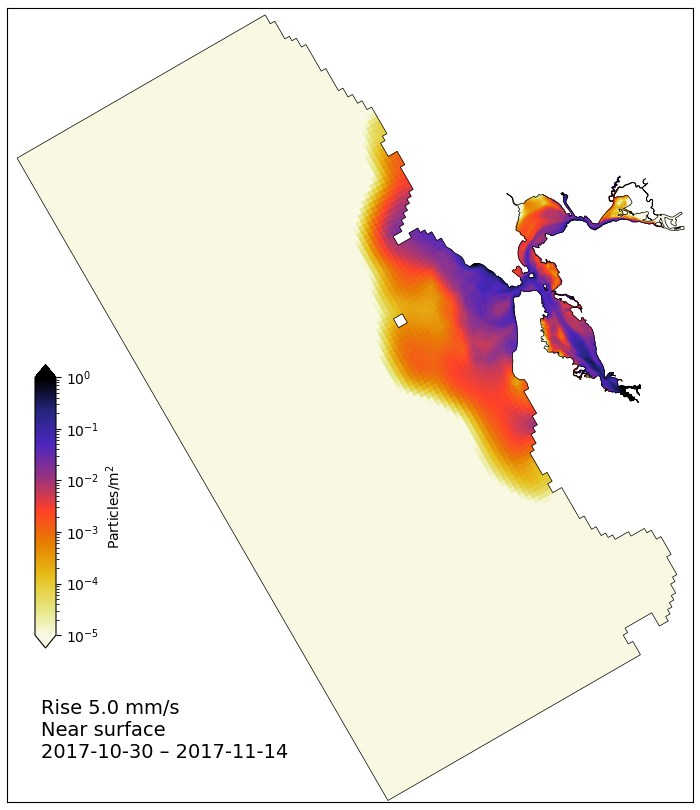

In [170]:
ds=xr.open_dataset(fns[56])
bf=CoastalConcFigure(ds,conc=smooth(ds.conc.values))
#                  figsize=(7,8.1),
#                  draw_boundary=True,
#                  vmin=1e-5,
#                  vmax=1,
#                  cmap=cmap,
#                  zoom=(345000., 613202., 4050000., 4230105.),
#                  cax_loc=[0.05,0.20,0.03,0.35],
#                  txt_loc=[0.05,0.13]) # in ax coords

In [177]:
# Check in on the combined runs:

In [23]:
ls processed/20180331_20180414/0.005/

particles-avg-44days-v05A.nc  particles-surf-44days-v05A.nc
particles-bed-44days-v05A.nc


In [32]:
# the v05B runs will have to wait for a new invocation, as spinup was not being passed.
dsA=xr.open_dataset('processed/20180331_20180414/0.005/particles-surf-44days-v05A.nc')

In [33]:
dsB=xr.open_dataset('processed/20180331_20180414/0.005/particles-surf-44days-v05B.nc')

In [29]:
conc=smooth(dsA.conc + ds.conc)

<IPython.core.display.Javascript object>


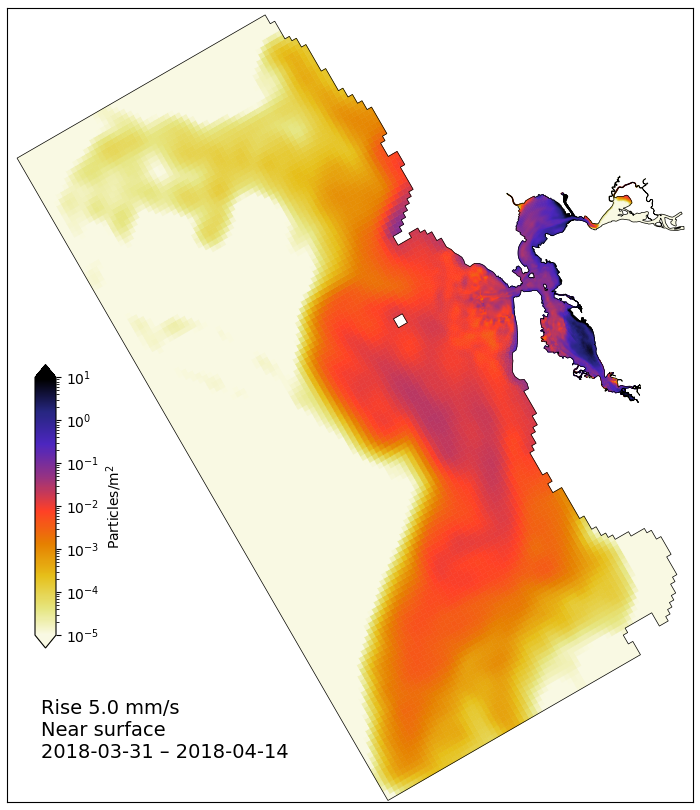

In [34]:
CoastalConcFigure(dsA,conc,vmax=10)